# CURVE AB

This notebook is set up for data analysis and research.



```
P(s) = (X, Y, Z) = (
    L_A * s,          # X轴：线性化的A曲线长度
    x_B(t(s)),        # Y轴：B曲线x坐标
    y_B(t(s))         # Z轴：B曲线y坐标
)
```

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from svg.path import parse_path
from svg.path.path import Line, CubicBezier

In [154]:
# INPUT

# 输入曲线数据
A_d = "M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5"
B_d = "M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40"

In [155]:
def parse_svg_path(d):
    """解析SVG路径为贝塞尔曲线段
    
    Args:
        d (str): SVG路径字符串
    
    Returns:
        list: 包含曲线段信息的字典列表
    """
    path = parse_path(d)
    segments = []
    for e in path:
        if isinstance(e, CubicBezier):
            segments.append({
                'start': (e.start.real, e.start.imag),
                'c1': (e.control1.real, e.control1.imag),
                'c2': (e.control2.real, e.control2.imag),
                'end': (e.end.real, e.end.imag)
            })
        elif isinstance(e, Line):
            segments.append({
                'start': (e.start.real, e.start.imag),
                'end': (e.end.real, e.end.imag)
            })
    return segments

In [156]:
def bezier_sample(segments, n_samples=50):
    """采样贝塞尔曲线
    
    Args:
        segments (list): 曲线段列表
        n_samples (int): 每段曲线的采样点数
    
    Returns:
        np.array: 采样点数组，形状为 (n_points, 2)
    """
    points = []
    for seg in segments:
        if 'c1' in seg:  # 三次贝塞尔曲线
            t = np.linspace(0, 1, n_samples)
            x = (1-t)**3*seg['start'][0] + 3*(1-t)**2*t*seg['c1'][0] + 3*(1-t)*t**2*seg['c2'][0] + t**3*seg['end'][0]
            y = (1-t)**3*seg['start'][1] + 3*(1-t)**2*t*seg['c1'][1] + 3*(1-t)*t**2*seg['c2'][1] + t**3*seg['end'][1]
            points.extend(list(zip(x, y)))
        else:  # 直线段
            x = np.linspace(seg['start'][0], seg['end'][0], n_samples)
            y = np.linspace(seg['start'][1], seg['end'][1], n_samples)
            points.extend(list(zip(x, y)))
    return np.array(points)

In [157]:
def plot_bezier_curves(A_points, B_points, A_segments, B_segments):
    """绘制贝塞尔曲线及其控制点
    
    Args:
        A_points (np.array): A曲线的采样点
        B_points (np.array): B曲线的采样点
        A_segments (list): A曲线的段信息
        B_segments (list): B曲线的段信息
    """
    plt.figure(figsize=(12, 8))
    
    # 绘制曲线和采样点
    plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', label='Curve A', linewidth=1, alpha=0.5)
    plt.scatter(A_points[:, 0], -A_points[:, 1], c='blue', s=20, alpha=0.5, label='A Points')
    
    plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', label='Curve B', linewidth=1, alpha=0.5)
    plt.scatter(B_points[:, 0], -B_points[:, 1], c='red', s=20, alpha=0.5, label='B Points')
    
    # 绘制控制点
    for seg in A_segments:
        if 'c1' in seg:
            plt.plot(seg['start'][0], -seg['start'][1], 'bo', markersize=10, alpha=0.7)
            plt.plot(seg['c1'][0], -seg['c1'][1], 'bx', markersize=10, alpha=0.7)
            plt.plot(seg['c2'][0], -seg['c2'][1], 'bx', markersize=10, alpha=0.7)
            plt.plot(seg['end'][0], -seg['end'][1], 'bo', markersize=10, alpha=0.7)
    
    for seg in B_segments:
        if 'c1' in seg:
            plt.plot(seg['start'][0], -seg['start'][1], 'ro', markersize=10, alpha=0.7)
            plt.plot(seg['c1'][0], -seg['c1'][1], 'rx', markersize=10, alpha=0.7)
            plt.plot(seg['c2'][0], -seg['c2'][1], 'rx', markersize=10, alpha=0.7)
            plt.plot(seg['end'][0], -seg['end'][1], 'ro', markersize=10, alpha=0.7)
    
    plt.grid(True)
    plt.legend()
    plt.title('Bezier Curves with Sampling Points')
    plt.axis('equal')
    plt.xlim(-10, 190)
    plt.ylim(-70, 10)
    plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


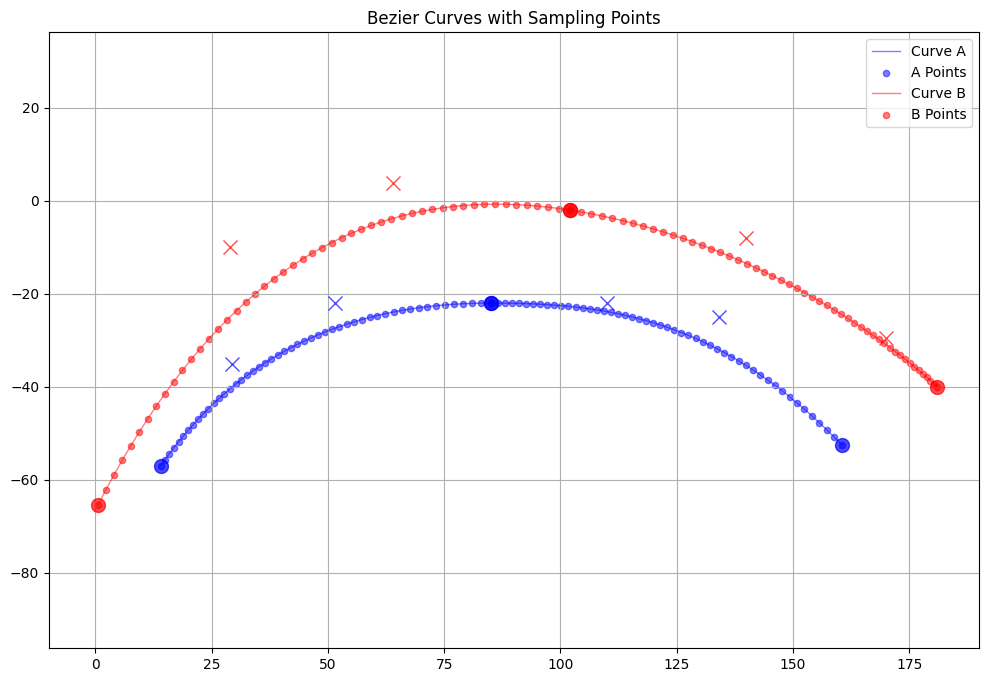

In [158]:


# 解析SVG路径
A_segments = parse_svg_path(A_d)
B_segments = parse_svg_path(B_d)

# 采样曲线
A_points = bezier_sample(A_segments, n_samples=50)
B_points = bezier_sample(B_segments, n_samples=50)

# 绘制曲线
plot_bezier_curves(A_points, B_points, A_segments, B_segments)

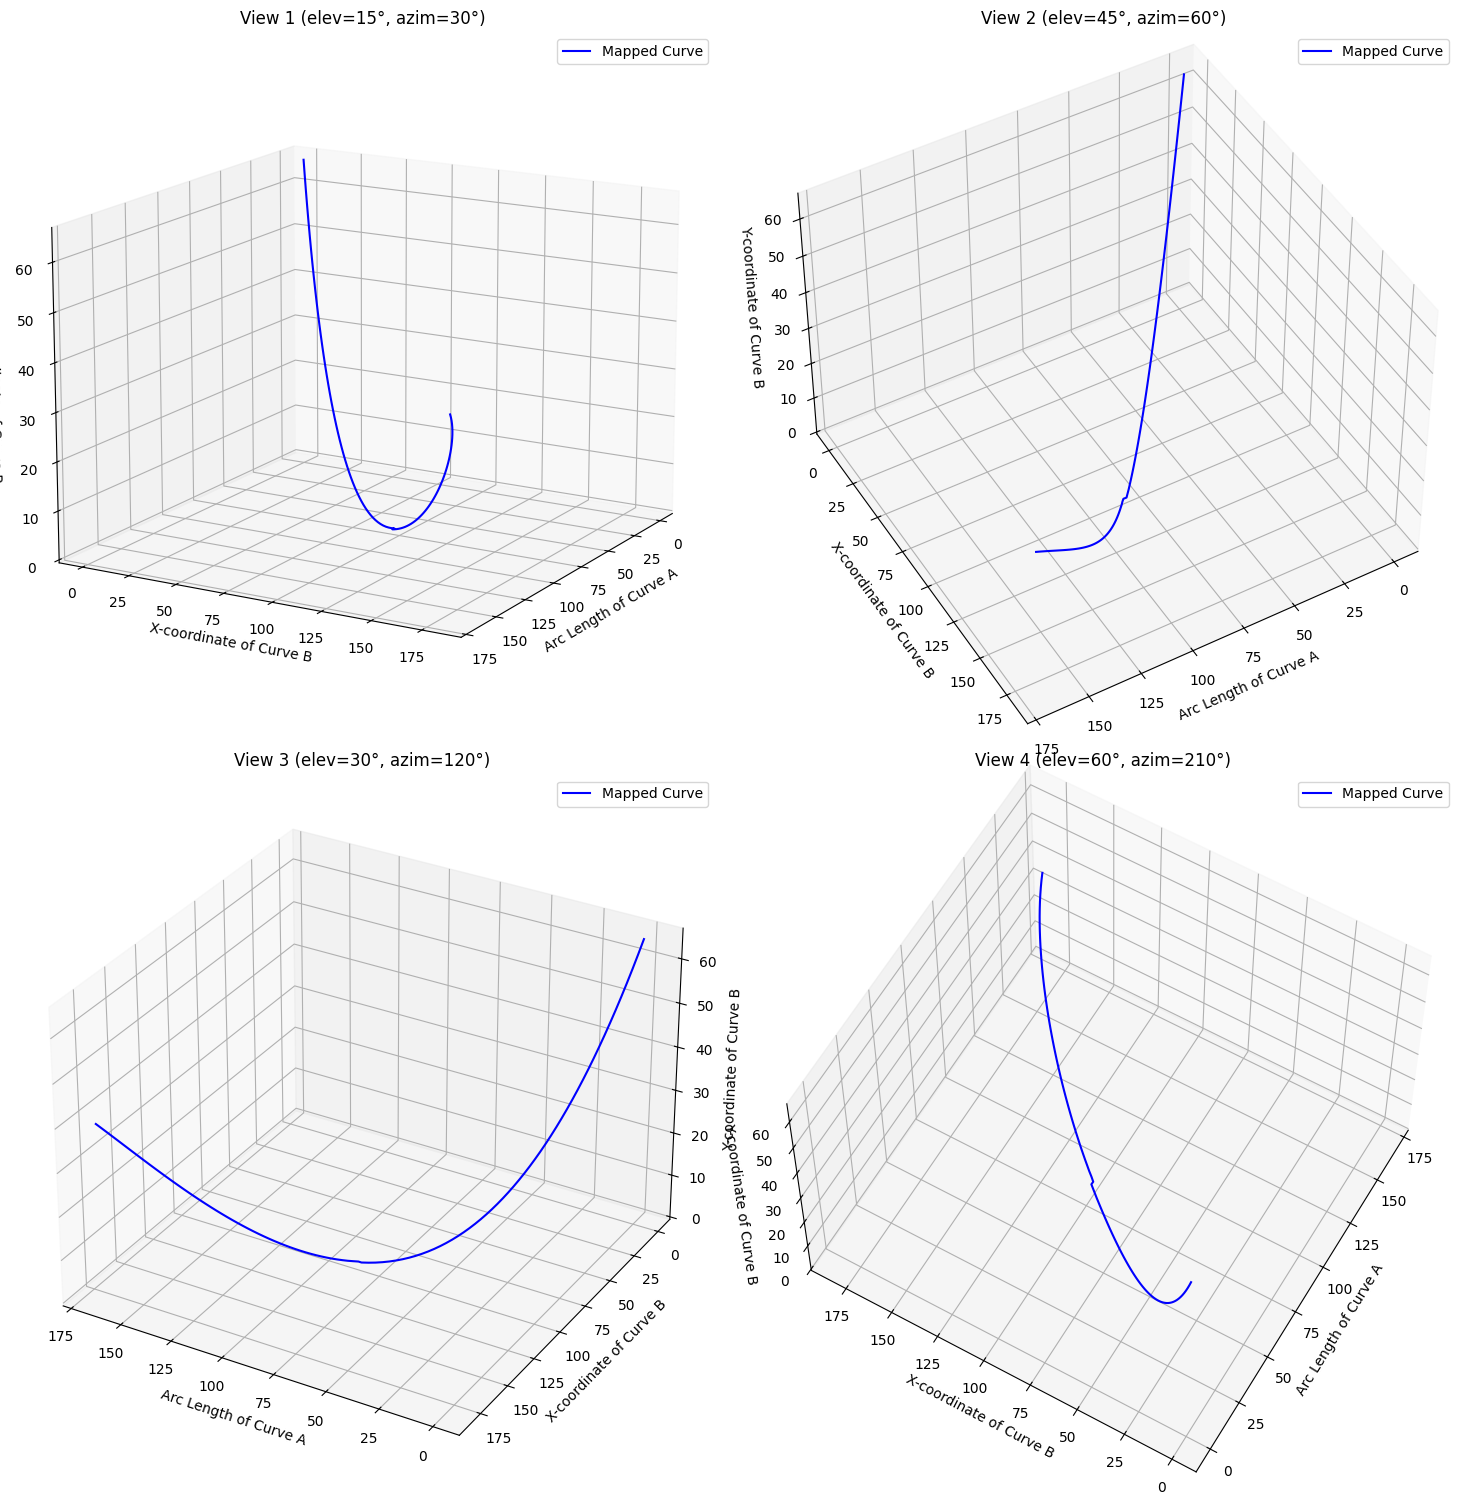

In [159]:
def arc_length_parameterization(points):
    """弧长参数化"""
    dx = np.diff(points[:,0])
    dy = np.diff(points[:,1])
    seg_lengths = np.sqrt(dx**2 + dy**2)
    cum_length = np.cumsum(seg_lengths)
    total_length = cum_length[-1]
    normalized = np.insert(cum_length, 0, 0) / total_length
    return normalized, total_length

# 计算曲线A的弧长参数化
s_A, L_A = arc_length_parameterization(A_points)

# 创建B曲线的参数化函数
t_B = np.linspace(0, 1, len(B_points))
cs_x = CubicSpline(t_B, B_points[:,0])
cs_y = CubicSpline(t_B, B_points[:,1])

# 生成三维映射
X = s_A * L_A  # X轴：A曲线的弧长
Y = cs_x(s_A)  # Y轴：B曲线x坐标
Z = cs_y(s_A)  # Z轴：B曲线y坐标

mapped_curve = np.column_stack((X, Y, Z))

# 创建2x2的子图布局
fig = plt.figure(figsize=(15, 15))

# 不同视角的设置
views = [
    (15, 30, 'View 1'),
    (45, 60, 'View 2'),
    (30, 120, 'View 3'),
    (60, 210, 'View 4')
]
for i, (elev, azim, title) in enumerate(views, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    

    ax.plot(X, Y, Z, 'b-', label='Mapped Curve')
    ax.set_xlabel('Arc Length of Curve A')
    ax.set_ylabel('X-coordinate of Curve B')
    ax.set_zlabel('Y-coordinate of Curve B')
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f'{title} (elev={elev}°, azim={azim}°)')
    ax.legend()

plt.tight_layout()
plt.show()


# Understanding Curve Parameterization: Why Use t(s) = argminₜ |s_A(t) - s|

## Two Approaches to Curve Parameterization

### 1. Direct Parameterization (Naive Approach)
```python
X = s_A * L_A
Y = cs_x(s_A)  # Directly using s_A as parameter t
Z = cs_y(s_A)
```
This method simply assumes that curve B's parameter t can be directly substituted with curve A's arc length parameter s. However, this assumption is generally incorrect as it ignores the geometric properties of the curves.

### 2. Optimized Parameterization
```python
t_values = [find_t_for_s(s, t_dense, s_B_dense) for s in s_values]
X = s_values * L_A
Y = cs_x(t_values)  # Using optimized t values
Z = cs_y(t_values)
```
This method finds the most appropriate parameter t on curve B that maintains the arc length proportion relationship with curve A.

## Why Use t(s) = argminₜ |s_A(t) - s|?

### 1. Arc Length Proportion Consistency
- When we traverse x% of curve A's total length
- We want to ensure we've also traversed exactly x% of curve B's total length
- The first approach cannot guarantee this as parameter t and arc length don't have a linear relationship
- The second approach ensures this correspondence through optimization

### 2. Geometric Significance
The formula t(s) = argminₜ |s_A(t) - s| means:
- When we are at position s on curve A
- We need to find a position t on curve B
- Such that at this position t, the arc length proportion of curve B is closest to s
- This ensures a more accurate geometric correspondence between the two curves

### 3. Speed Matching
- The naive approach may result in "moving too fast" in some regions and "too slow" in others
- The optimized approach adaptively adjusts parameter t to maintain coordinated "movement speed" between the two curves

## Concrete Example
Consider a case where:
- Curve A is a straight line
- Curve B is an S-shaped curve

Using direct parameterization (s_A as t):
- Would cause "crowding" in the curved portions of the S-curve
- Points would be unevenly distributed

Using t(s) = argminₜ |s_A(t) - s|:
- Automatically adjusts the parameter t
- Slows down in curved portions of the S-curve
- Speeds up in straighter portions
- Maintains consistent arc length proportions

## Mathematical Implementation
```python
def find_t_for_s(s_target, t_samples, s_samples):
    """
    Find t that minimizes |s_A(t) - s|
    
    Parameters:
    s_target: target s value
    t_samples: sampled t values
    s_samples: corresponding s values
    
    Returns:
    t value that minimizes |s_A(t) - s_target|
    """
    idx = np.argmin(np.abs(s_samples - s_target))
    return t_samples[idx]
```

## Benefits
1. **Geometric Accuracy**: Maintains true geometric relationships between curves
2. **Uniform Distribution**: Ensures even point distribution along both curves
3. **Proportional Mapping**: Preserves arc length proportions
4. **Speed Adaptation**: Automatically adjusts for varying curvature

This approach produces a more accurate, geometrically meaningful mapping between the two curves, making it the preferred method for curve parameterization and comparison.


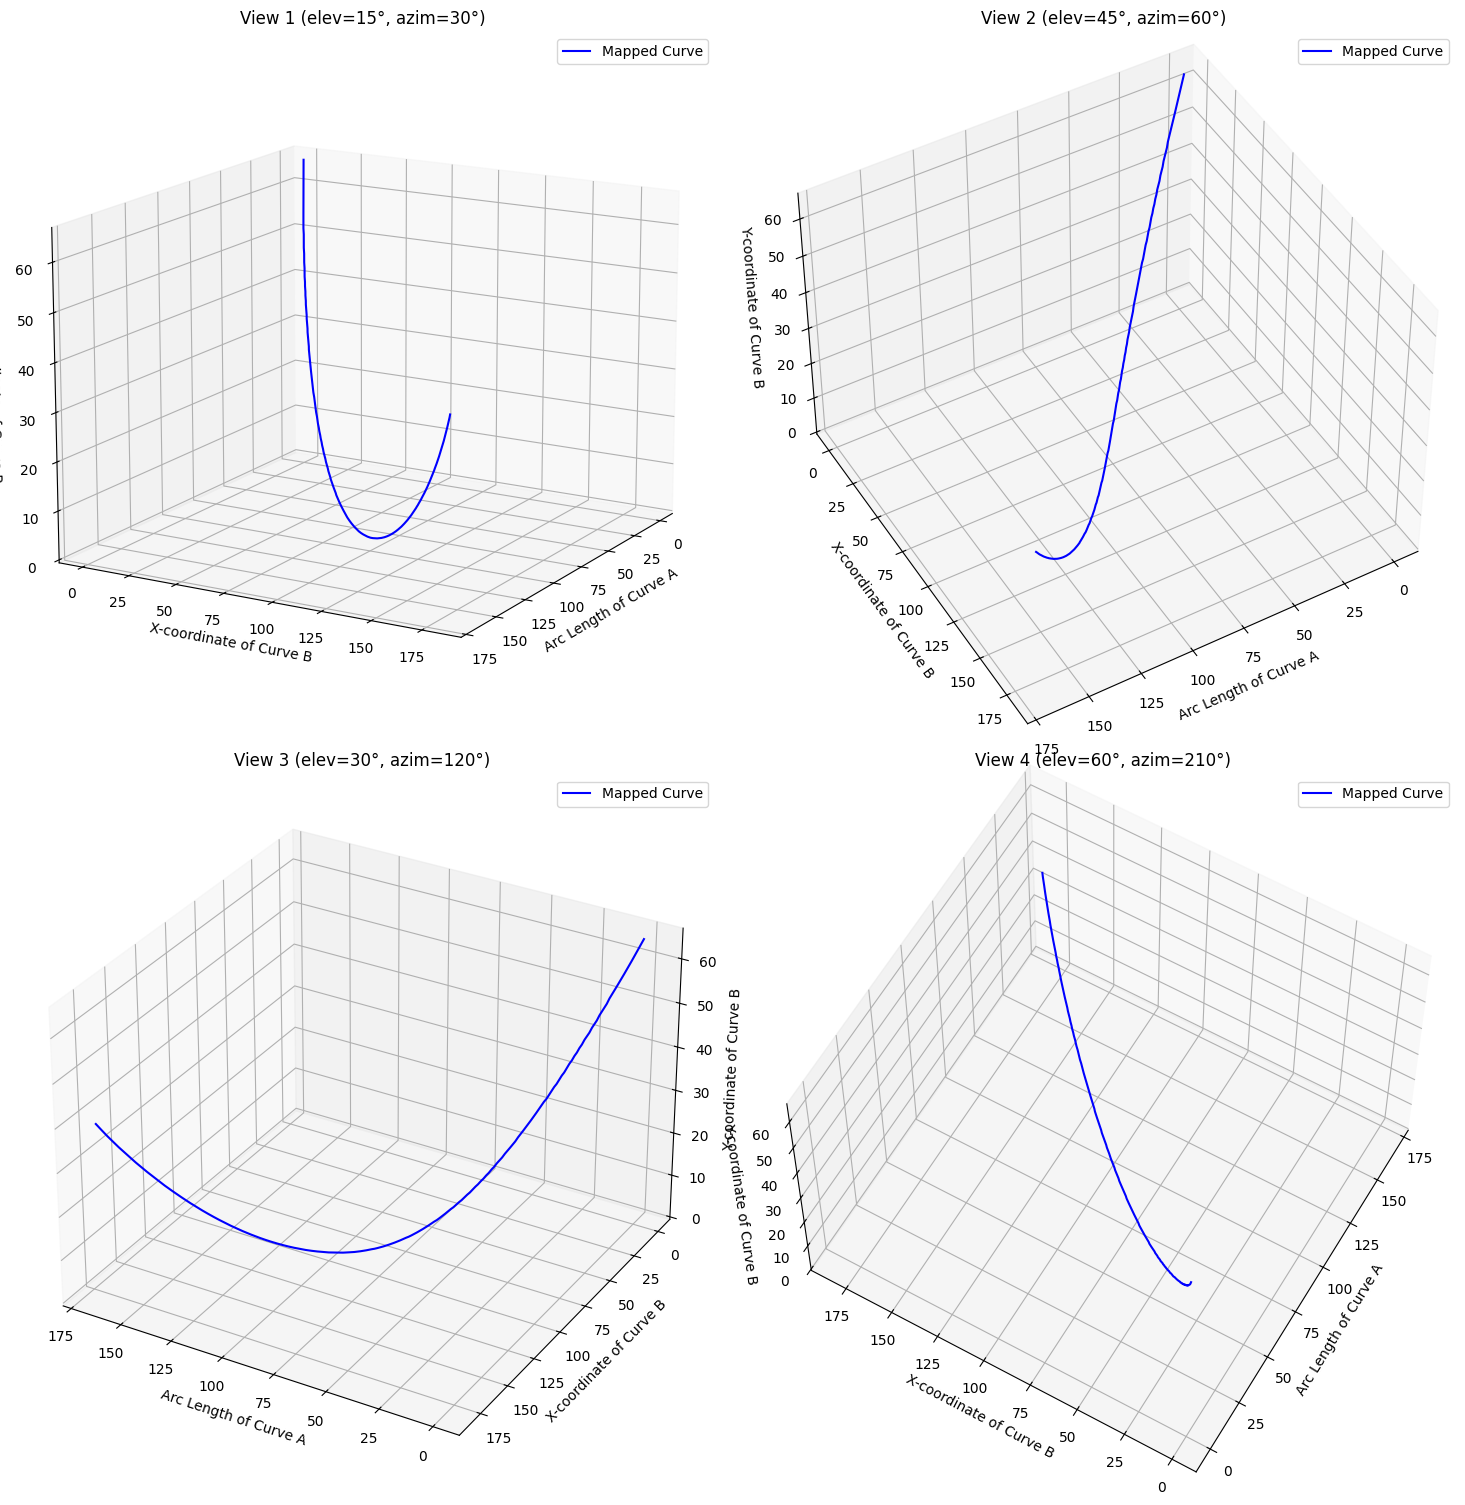

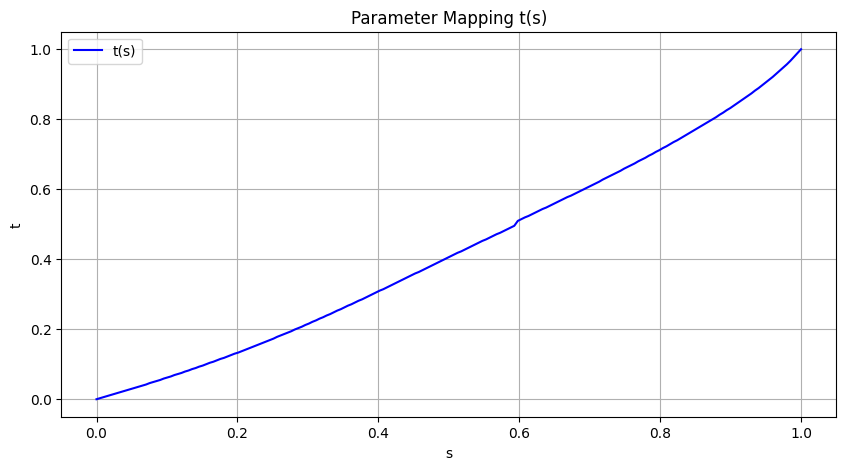

In [160]:
def arc_length_parameterization(points):
    """弧长参数化"""
    dx = np.diff(points[:,0])
    dy = np.diff(points[:,1])
    seg_lengths = np.sqrt(dx**2 + dy**2)
    cum_length = np.cumsum(seg_lengths)
    total_length = cum_length[-1]
    normalized = np.insert(cum_length, 0, 0) / total_length
    return normalized, total_length

def find_t_for_s(s_target, t_samples, s_samples):
    """
    找到使得 |s_A(t) - s| 最小的 t 值
    
    参数:
    s_target: 目标s值
    t_samples: t的采样点
    s_samples: 对应的s值采样点
    
    返回:
    使得|s_A(t) - s_target|最小的t值
    """
    idx = np.argmin(np.abs(s_samples - s_target))
    return t_samples[idx]

# 计算曲线A的弧长参数化
s_A, L_A = arc_length_parameterization(A_points)

# 为曲线B创建更密集的采样点
num_samples = 1000
t_dense = np.linspace(0, 1, num_samples)
B_dense = np.column_stack([
    np.interp(t_dense, np.linspace(0, 1, len(B_points)), B_points[:,0]),
    np.interp(t_dense, np.linspace(0, 1, len(B_points)), B_points[:,1])
])

# 计算密集采样点的弧长参数化
s_B_dense, _ = arc_length_parameterization(B_dense)

# 对每个目标s值找到对应的t值
s_values = np.linspace(0, 1, 200)  # 用于最终曲线的采样点
t_values = np.array([find_t_for_s(s, t_dense, s_B_dense) for s in s_values])

# 创建B曲线的参数化函数
cs_x = CubicSpline(t_dense, B_dense[:,0])
cs_y = CubicSpline(t_dense, B_dense[:,1])

# 生成三维映射
X = s_values * L_A      # X轴：A曲线的弧长
Y = cs_x(t_values)      # Y轴：B曲线x坐标
Z = cs_y(t_values)      # Z轴：B曲线y坐标

mapped_curve = np.column_stack((X, Y, Z))

# 创建2x2的子图布局
fig = plt.figure(figsize=(15, 15))

# 不同视角的设置
views = [
    (15, 30, 'View 1'),
    (45, 60, 'View 2'),
    (30, 120, 'View 3'),
    (60, 210, 'View 4')
]

for i, (elev, azim, title) in enumerate(views, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    
    ax.plot(X, Y, Z, 'b-', label='Mapped Curve')
    ax.set_xlabel('Arc Length of Curve A')
    ax.set_ylabel('X-coordinate of Curve B')
    ax.set_zlabel('Y-coordinate of Curve B')
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f'{title} (elev={elev}°, azim={azim}°)')
    ax.legend()

plt.tight_layout()
plt.show()

# 可选：绘制参数化关系图
plt.figure(figsize=(10, 5))
plt.plot(s_values, t_values, 'b-', label='t(s)')
plt.xlabel('s')
plt.ylabel('t')
plt.title('Parameter Mapping t(s)')
plt.grid(True)
plt.legend()
plt.show()